In [1]:
from os import sys, path, getcwd
sys.path.append(path.dirname(getcwd()))

import numpy as np
import scipy.integrate as integrate
import scipy.stats as stats
import matplotlib.pyplot as plt
import ipywidgets as widgets
from particle_approximation import ParticleApproximation
from gaussian_kde import gaussian_kde

In [2]:
plt.figure(figsize=(9,6))
plt.rc('font', size=15);

<Figure size 900x600 with 0 Axes>

## Preparation Code

In [3]:
x_0 = [5*np.pi/180, 0]
def pendulum_rhs(x, t, g):
    d_x = x[1]
    d2_x = -g/7.4 * np.sin(x[0])
    return [d_x, d2_x]

def solve(g, times):
    sol = integrate.odeint(pendulum_rhs, x_0, times, args=(g,))
    return sol[:,0]

prior = stats.truncnorm(-10, 10, loc=10, scale=1) 
error_model = stats.norm(0,0.05)

observations = np.array([1.51, 4.06, 7.06, 9.90, 12.66, 15.40, 15.58, 18.56, 21.38, 24.36])
evaluation_mesh = np.append(0, observations)

def loglikelihood(g, n):
    if n == 0:
        return 0
    return error_model.logpdf(solve(g, evaluation_mesh[:n+1])[1:]).sum()    
vloglikelihood = np.vectorize(loglikelihood)

def gaussian_proposal(x):
    return stats.norm(loc=x, scale=.25).rvs() 

## Posteriors densities (Fig. 3)

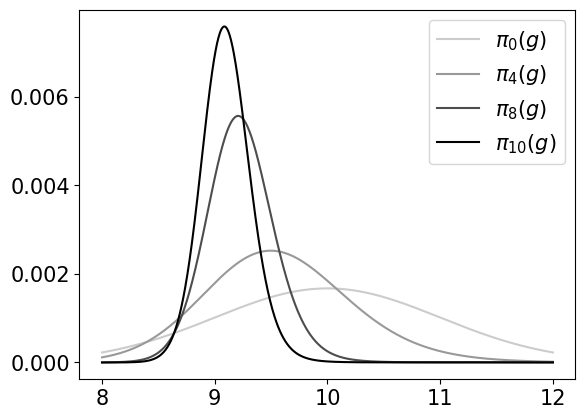

In [4]:
g_values = np.linspace(8, 12, 1000)
approx_densities = np.zeros((1000,observations.size+1))

for i in range(observations.size+1):
    log_density = prior.logpdf(g_values) + vloglikelihood(g_values, i)
    approx_densities[:,i] = np.exp(log_density)
    approx_densities[:,i] /= approx_densities[:,i].sum()

cs = [0.8, 0.6, 0.3, 0]
for idx,i in enumerate([0, 4, 8, 10]):
    c = cs[idx]
    plt.plot(g_values, approx_densities[:,i], color=(c,c,c), label="$\pi_{%s}(g)$" % i)

plt.legend(); 

## SIS - ESS reduction (Fig. 7)

In [5]:
approximation_sis = ParticleApproximation(2500, prior)
ess_evolution_sis = np.zeros(observations.size+1)
ess_evolution_sis[0] = 2500

for n in range(1,observations.size+1):
    importance_potential = lambda x: vloglikelihood(x, n-1)
    target_potential = lambda x: vloglikelihood(x, n)

    approximation_sis.reweight(importance_potential, target_potential)
    ess_evolution_sis[n] = approximation_sis.effective_sample_size() 

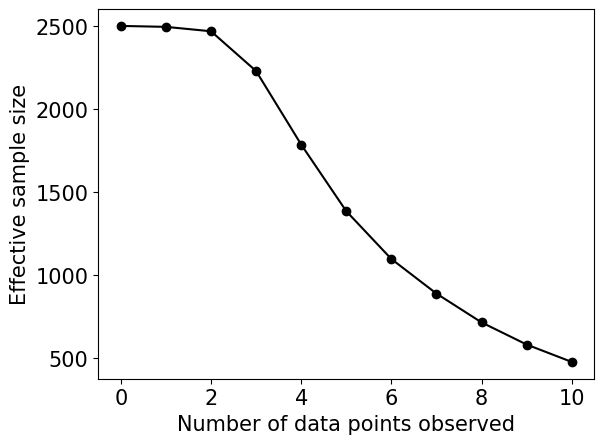

In [6]:
plt.xlabel("Number of data points observed")
plt.ylabel("Effective sample size")
plt.plot(ess_evolution_sis, color="black")
plt.scatter(range(observations.size+1),ess_evolution_sis, color="black"); 

## SMC - ESS & Convergence (Fig. 8)

In [7]:
approximation_smc = ParticleApproximation(2500, prior)
ess_evolution_smc = np.zeros(observations.size+1)
ess_evolution_smc[0] = 2500

for n in range(1,observations.size+1):
    importance_potential = lambda x: vloglikelihood(x, n-1)
    target_potential = lambda x: vloglikelihood(x, n)

    _,ess = approximation_smc.smc_update(importance_potential, target_potential, gaussian_proposal, correction_steps=5, ess_ratio=1.3)
    ess_evolution_smc[n] = ess

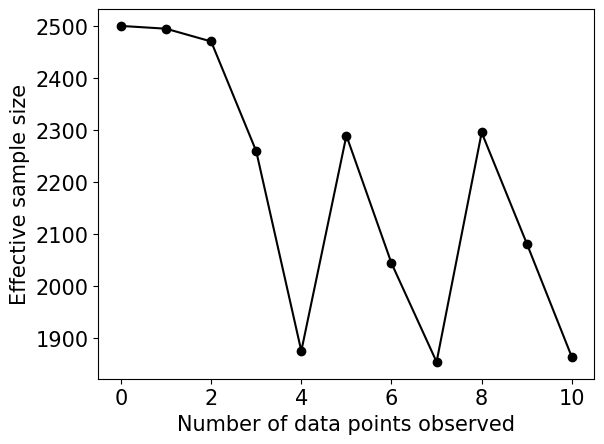

In [8]:
plt.xlabel("Number of data points observed")
plt.ylabel("Effective sample size")
plt.plot(ess_evolution_smc, color="black")
plt.scatter(range(observations.size+1),ess_evolution_smc, color="black"); 

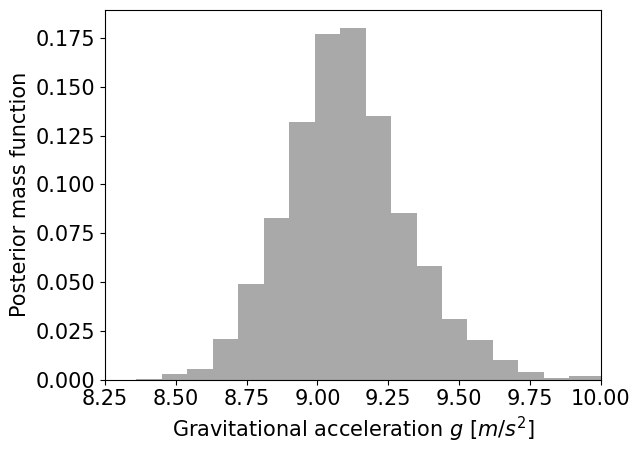

In [9]:
plt.ylabel("Posterior mass function")
plt.xlabel("Gravitational acceleration $g$ [$m/s^2$]")
plt.xlim(8.25, 10)
approximation_smc.hist(bins=40, color="darkgrey") 

## Convergence

In [ ]:
Ns = range(4,13)
trials = 50

means_smc = np.zeros((len(Ns),trials))
means_sis = np.zeros((len(Ns),trials))

for n,N in enumerate(Ns):
    for i in range(trials):
        #pa = ParticleApproximation.load('benchmark/smc/approx_%d_%d_10.npz' % (2**N,i+1), prior)
        #means_smc[n,i] = pa.integrate(lambda x: x)
        
        pa = ParticleApproximation.load('benchmark/sis/approx_%d_%d.npz' % (2**N,i+1), prior)
        means_sis[n,i] = pa.integrate(lambda x: x) 

### SIS Convergence (Fig. 6)

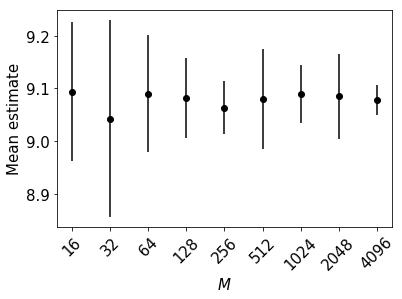

In [11]:
plt.xlabel("$M$")
plt.ylabel("Mean estimate")
plt.xticks(Ns, np.power(2, Ns), rotation=45)
plt.errorbar(Ns, np.mean(means_sis, axis=1), yerr=np.std(means_sis, axis=1), fmt="o", c="black");

### SMC Convergence

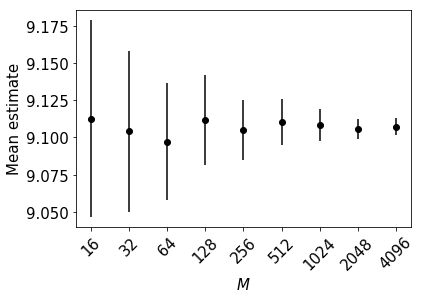

In [13]:
plt.xlabel("$M$")
plt.ylabel("Mean estimate")
plt.xticks(Ns, np.power(2, Ns), rotation=45)
plt.errorbar(Ns, np.mean(means_smc, axis=1), yerr=np.std(means_smc, axis=1), fmt="o", c="black");

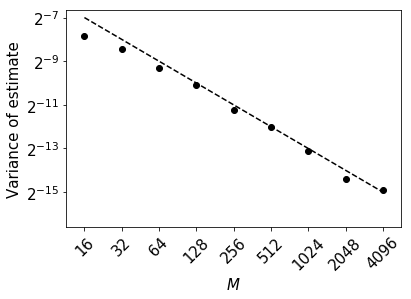

In [27]:
fig = plt.figure()
ax = plt.gca()

plt.xlabel("$M$")
plt.ylabel("Variance of estimate")
plt.plot(np.power(2,Ns), np.power(2.0,-3 - np.array(Ns)), c="black", linestyle="--")

ax.set_yscale('log', basey=2)
ax.set_xscale('log', basex=2)
plt.ylim(1e-05, 0.01)

plt.scatter(np.power(2,Ns), np.var(means_smc, axis=1), c="black")
plt.xticks(np.power(2, Ns), np.power(2, Ns), rotation=45);

## MCMC Ref Solution (Fig. 9)

In [4]:
def mcmc(prior, log_likelihood, proposal_kernel, n_samples=5000, burnin=500):
    x = prior.rvs()
    x_prob = log_likelihood(x) + prior.logpdf(x)
    
    result = np.zeros((n_samples,np.size(x)))
    result[0,:] = x
    for i in range(1,n_samples+burnin):
        proposal = proposal_kernel(x)
        proposal_prob = log_likelihood(proposal) + prior.logpdf(proposal)
        
        u = np.log(np.random.uniform())
        if u < proposal_prob - x_prob:
            x = proposal
            x_prob = proposal_prob
        if i >= burnin:
            result[i-burnin,:] = x
    return result

xs = mcmc(prior, lambda x: loglikelihood(x,observations.size+1), gaussian_proposal, n_samples=2500, burnin=250)

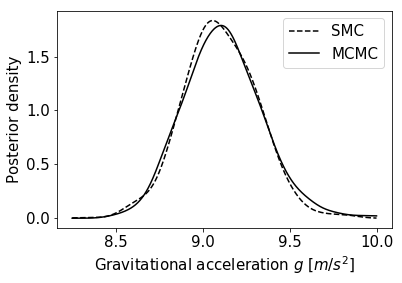

In [7]:
plt.ylabel("Posterior density")
plt.xlabel("Gravitational acceleration $g$ [$m/s^2$]")

bw_method = 0.3
_xs = np.linspace(8.25,10, 1000)

kde = gaussian_kde(dataset=approximation_smc.particles, weights=approximation_smc.weights, bw_method=bw_method)
_ys = kde.evaluate(_xs)
plt.plot(_xs,_ys,linestyle="--", color="black",label="SMC")
kde = gaussian_kde(dataset=xs.flatten(), weights=np.ones(2500)/2500, bw_method=bw_method)
_ys = kde.evaluate(_xs)
plt.plot(_xs,_ys,color="black",label="MCMC")
plt.legend(); 